<a href="https://colab.research.google.com/github/Buitragox/Crowdsourcing-Thesis/blob/main/notebooks/Image_mask_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing of histological images

This notebook is responsible for preprocessing histological images.

First, the color of the images is normalized to avoid differences in colors due to the various sources of the images. For this, Reinhard color normalization is used, which adjusts the images based on their mean and standard deviation.

After this, patches from the 151 already normalized histological images are generated using a 224x224 sliding window, ensuring that each image represents at least 50% of one of the classes (1=tumor, 2=stroma, 3=benign inflammation).

https://github.com/wizmik12/crowdsourcing-digital-pathology-GPs

Instalar librerías necesarias

- https://pypi.org/project/histomicstk/#description

In [ ]:
!python -m pip install histomicstk --find-links https://girder.github.io/large_image_wheels -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.1/210.1 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.2/248.2 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 15.7 MB/

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import skimage.io as io
import tensorflow as tf
#import histomicstk as htk
from matplotlib import pyplot as plt

Las imagenes procesadas serán subidas a drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

#Color Normalization

In [ ]:
core_path = './drive/MyDrive/datasets/BCTS/'
normalized_path = core_path + 'normalized_images/'
images_path = core_path + 'images/'
masks_path = core_path + 'masks/'

if not os.path.exists(normalized_path):
    os.makedirs(normalized_path)

image_list =  os.listdir(images_path)

# Reference image used for normalization
ref_image_path = images_path + image_list[0]

IndexError: ignored

Reinhard color normalization is used for each of the images.

htk.preprocessing.color_normalization.reinhard(): "Transform the color characteristics of an image to a desired standard. The standard is defined by the mean and standard deviations of the target image in LAB color space..."

In [ ]:
ref_image =  cv2.imread(ref_image_path)

ref_image_mean, ref_image_std =  htk.preprocessing.color_conversion.lab_mean_std(ref_image)

for i, image in enumerate(image_list):
    print(f"Normalizing image #{i + 1} / {len(image_list)} - {image}")

    image_path =  images_path + image
    image_RGB =  cv2.imread(image_path)

    image_normalized =  htk.preprocessing.color_normalization.reinhard(image_RGB, ref_image_mean, ref_image_std)

    save_path = normalized_path + image
    cv2.imwrite(save_path, image_normalized)

Normalizing image #1 / 150 - TCGA-A1-A0SP-DX1_xmin6798_ymin53719_MPP-0.2500.png
Normalizing image #2 / 150 - TCGA-A2-A04P-DX1_xmin104246_ymin48517_MPP-0.2500.png
Normalizing image #3 / 150 - TCGA-A2-A04Q-DX1_xmin20868_ymin17804_MPP-0.2500.png
Normalizing image #4 / 150 - TCGA-A2-A04T-DX1_xmin72145_ymin39078_MPP-0.2500.png


KeyboardInterrupt: ignored

# Extracting Patches

In [ ]:
def labeling(annotation_mask):
    #Convert the annotation mask into a label mask (the three that we are considering tumor, stroma and other).
    """
    Codes based on gtruth_codes.tsv taken from https://github.com/PathologyDataScience/BCSS
    1 = tumor
    19 = angioinvasion
    20 = dcis
    2 = stroma
    3 = lymphocytic_infiltrate
    10 = plasma_cells
    11 = other_immune_infiltrate
    """

    label_mask = 4 * np.ones(annotation_mask.shape, dtype=np.uint8) #other = 4
    label_mask[np.logical_or(annotation_mask==1,annotation_mask==19,annotation_mask==20)] = 1 #tumor = 1
    label_mask[annotation_mask==2] = 2 #stroma = 2
    label_mask[np.logical_or(annotation_mask==3,annotation_mask==10,annotation_mask==11)] = 3 #lymphocytic infiltrate = 3
    return label_mask

def label_image(label_mask):
    #If the mask has more than the 50% of one class assigns it to this class.
    pixels = label_mask.shape[0]*label_mask.shape[1]
    for i in range(1,4):
        if (label_mask==i).sum()/pixels >= 0.5:
            return i
    return False

def sliding_window(image, percent_overlap, windowSize):
    # slide a window across the image
    stepSize = int((1 - percent_overlap) * windowSize[0])
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (int(x), int(y), image[y:y + windowSize[1], x:x + windowSize[0]])

In [ ]:
patches_path = core_path + 'patches/'
images_patch_path = patches_path + "images/"
mask_patch_path = patches_path + "masks/"

if not os.path.exists(patches_path):
    os.makedirs(patches_path)

if not os.path.exists(images_patch_path):
    os.makedirs(images_patch_path)

if not os.path.exists(mask_patch_path):
    os.makedirs(mask_patch_path)

image_list = os.listdir(normalized_path)

mask_list = os.listdir(masks_path)

Fragments of each image with their respective masks, sized 224x224, are taken.

The fragments taken must meet the requirement that at least one class has a minimum of 50% pixel assignment in the original image.

The sliding_window() function is responsible for fragmenting the image.

In [ ]:
core_set_patches = pd.DataFrame({'im':[],'patch':[],'name': [], 'institute': [], 'label':[], 'x':[], 'y':[]})

for i, image in enumerate(image_list):

    if (i + 1) < 61:
        continue

    print(f"Image #{i + 1} / {len(image_list)} - {image}")

    #Paths of the normalized image and mask
    norm_image_path = normalized_path + image
    institute, name_image = image.split('-')[1], image.split('-')[2]

    #Get the respective mask of the image
    for m in mask_list:
        if name_image in m:
            mask = m
            break

    image_mask = masks_path + mask

    #Reading mask and image
    image_RGB = io.imread(norm_image_path)
    annotation_mask = io.imread(image_mask)

    #Labeling the image
    mask_label = labeling(annotation_mask)

    #Getting image patches
    for (x, y, window) in sliding_window(mask_label, percent_overlap=0.0, windowSize=(224, 224)):
        # if the window does not meet the desired window size, ignore it
        label = label_image(window)
        if window.shape[0] == 224 and window.shape[1] == 224 and label:

            image_save_path = images_patch_path + "/" + name_image + "_" + institute + "_x_ini_" + str(x) + "_y_ini_" + str(y) + ".png"
            io.imsave(image_save_path, image_RGB[y:y + 224, x:x + 224], check_contrast=False)

            df_im = pd.DataFrame({'im':[image],'patch': [name_image + "_" + institute + "_x_ini_" + str(x) + "_y_ini_" + str(y) + ".png"],
                                  'name': [name_image], 'institute': [institute], 'label':[label], 'x':[x], 'y':[y]})

            mask_save_path = mask_patch_path + "/" + name_image + "_" + institute + "_x_ini_" + str(x) + "_y_ini_" + str(y) + ".png"
            io.imsave(mask_save_path, mask_label[y:y + 224, x:x + 224], check_contrast=False)

            core_set_patches = [core_set_patches, df_im]
            core_set_patches = pd.concat(core_set_patches)

core_set_patches.to_csv(core_path + "corrected_set_patches.csv", float_format="%.0f")

Image #61 / 151 - TCGA-AR-A256-DX1_xmin41577_ymin17076_MPP-0.2500.png
Image #62 / 151 - TCGA-AR-A2LH-DX1_xmin78480_ymin42305_MPP-0.2500.png
Image #63 / 151 - TCGA-AR-A2LR-DX1_xmin46540_ymin31961_MPP-0.2500.png
Image #64 / 151 - TCGA-AR-A5QQ-DX1_xmin107130_ymin49863_MPP-0.2500.png
Image #65 / 151 - TCGA-BH-A0AV-DX1_xmin77937_ymin57165_MPP-0.2500.png
Image #66 / 151 - TCGA-BH-A0B3-DX1_xmin82526_ymin42184_MPP-0.2500.png
Image #67 / 151 - TCGA-BH-A0B9-DX1_xmin62727_ymin56697_MPP-0.2500.png
Image #68 / 151 - TCGA-BH-A0BG-DX1_xmin64019_ymin24975_MPP-0.2500.png
Image #69 / 151 - TCGA-BH-A0BL-DX1_xmin25219_ymin42847_MPP-0.2500.png
Image #70 / 151 - TCGA-BH-A0BW-DX1_xmin42346_ymin30843_MPP-0.2500.png
Image #71 / 151 - TCGA-BH-A0E0-DX1_xmin16640_ymin43761_MPP-0.2500.png
Image #72 / 151 - TCGA-BH-A0E6-DX1_xmin54786_ymin20002_MPP-0.2500.png
Image #73 / 151 - TCGA-BH-A0RX-DX1_xmin69099_ymin22327_MPP-0.2500.png
Image #74 / 151 - TCGA-BH-A0WA-DX1_xmin56581_ymin24774_MPP-0.2500.png
Image #75 / 151 - T

51592, 32785

In [ ]:
#Testing and counting the number of patches.

#A0AL_AN_x_ini_0_y_ini_0.png
#A0AR_AN_x_ini_0_y_ini_0.png

img_name = "A0AR_AN_x_ini_0_y_ini_0.png"

test_image_path = images_patch_path + img_name
test_mask_path = mask_patch_path + img_name

image_list = os.listdir(mask_patch_path)
print("Amount of patches:", len(image_list))
print("Find A0AR_AN_x_ini_0_y_ini_0:", bool(image_list.count(img_name)))

Amount of patches: 32785
Find A0AR_AN_x_ini_0_y_ini_0: True


In [ ]:
tumor_RGB = (255, 0, 0)
stroma_RGB = (0, 0, 255)
infiltrate_RGB = (0, 255, 0)

def change_mask_colors(mask_RGB):
    # label values: 1 = tumor, 2 = stroma, 3 = infiltrate

    replace_list = [tumor_RGB, stroma_RGB, infiltrate_RGB]

    for i, rgb in enumerate(replace_list):
        label = i + 1

        r1, g1, b1 = label, label, label # Original value
        r2, g2, b2 = rgb # Value that we want to replace it with

        red, green, blue = mask_RGB[:,:,0], mask_RGB[:,:,1], mask_RGB[:,:,2]
        mask = (red == r1) & (green == g1) & (blue == b1)
        mask_RGB[:,:,:3][mask] = [r2, g2, b2]

    #return mask_RGB


def print_image_with_mask(image_path, mask_path):
    print("Showing:", os.path.basename(image_path))
    mask_GRAY = io.imread(mask_path)
    image_RGB = io.imread(image_path)

    #Change colors of the mask for better contrast.
    #mask_GRAY[mask_GRAY == 2] = 50
    #mask_GRAY[mask_GRAY == 3] = 100

    #Give the image 3 channels (224x224x3)
    mask_RGB = cv2.cvtColor(mask_GRAY, cv2.COLOR_GRAY2RGB)
    #mask_RGB[mask_RGB == 2] = 50
    #mask_RGB[mask_RGB == 3] = 100

    change_mask_colors(mask_RGB)

    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image_RGB)
    axarr[1].imshow(mask_RGB)

    plt.show()

Showing: A18V_BH_x_ini_2240_y_ini_1120.png


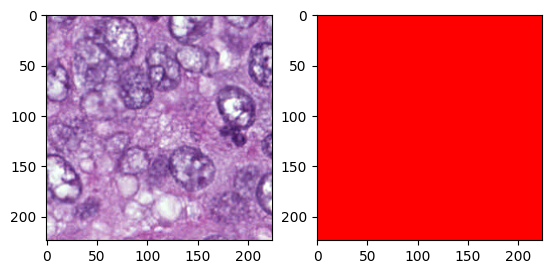

In [ ]:
rng = np.random.default_rng()
img_name = rng.choice(image_list)
print_image_with_mask(images_patch_path + img_name, mask_patch_path + img_name)